# Project 8: US Airline Sentiment Analysis using Twitter Data

**Background:** Can we accuratley predict the sentiment expressed in a line of text like a product review or a tweet?
The ability to do so effectively can offer numerous opportunities to an organization including tracking customer opinion over time, reducing customer churn, and identifying upselling opportunities to name but a few. 

The data for the project was provided by Crowdflower's Data for Everyone library and was latter shared on Kaggle. It consists of scrapped customer tweets, from 2015, that were directed at several prominent U.S. airline companies.

**Objective:** Develop a Bag-of-Words model to accurately predict the sentiment expressed in a line of text. 

The project will be broken into several steps:

1. [Import the libraries and datasets](#1)
2. [Data Exploration](#2)
2. [Text Preprocessing](#3)
3. [Vectorization of Text Data](#4)
4. [Model Fitting and Evaluation](#5)
5. [Summary](#6)

<a id="1"></a>
## Step 1: Import Libraries and Load Dataset

In [34]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# preprocessing libraries
from bs4 import BeautifulSoup
import re
import spacy

# import vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# models
from sklearn.linear_model import LogisticRegression

# model selection
from sklearn.model_selection import train_test_split, cross_val_score

# metrics
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [88]:
# Load Data
data = pd.read_csv("/content/gdrive/My Drive/PMP AIML/Sentiment Analysis/Tweets.csv")

In [89]:
# print the shape of the data 
print("The data set contains {:,} rows and {:,} columns.".format(data.shape[0],data.shape[1]))

The data set contains 14,640 rows and 15 columns.


In [90]:
# check for mising values
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

There are no missing values in either the airline_sentiment or text columns. We are not concerned with the missing values in the other columns since they will not be used in the analysis.

In [8]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The data consists of 14 features ranging from the tweet itself, the airline, and the reason for a negative tweet. Our target column, airline_sentiment, identifies whether the expressed sentiment is positive, negative, or neutral. In the next section we will perform some quick data exploration and then prep the data for the later steps of text preprocessing.

<a id="2"></a>
## Step 2: Data Exploration

In this section we explore the class distribution in our target column. We will also explore the sentiments broken out by airline and the leading causes that prompt a customer to post a negative tweet.

In [9]:
# class distribution in the target column
data.airline_sentiment.value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

We observe three classes in the target column and hence this will be a multi-class classification task. We also observe that 63% of the tweets in dataset are negative, 21% are neutral, and 16% are positive. This follows the trend that people are more likely to leave negative reviews rather than positive ones. This **uneven class distribtion** might make it difficult for our model to correctly identify positive sentiments. If that turns out to be the case we can consider **upsampling** or **downsampling** to combat the issue if it arises.

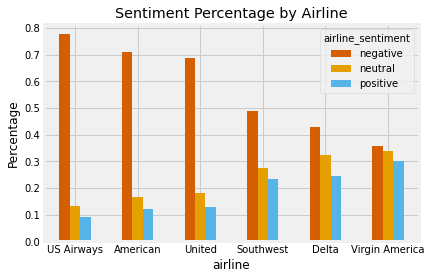

In [101]:
# normalized sentiment by airline
sentiment_perc_by_airline = pd.crosstab(data.airline, data.airline_sentiment, normalize='index').sort_values('positive')

colors = [[213/255,94/255,0], [230/255,159/255,0], [86/255,180/255,233/255]]
sentiment_perc_by_airline.plot.bar(color=colors);
plt.ylabel("Percentage");
plt.xticks(rotation = 0);
plt.title("Sentiment Percentage by Airline");

United, American, and Us Airways as a whole recieved the most negative tweets. Out of all the tweets directed at US Airways 79% of them were negative! Virgin America stands out from the rest as the percentage of negative tweets they received is almost comparable to their number of positive and neutral tweets.

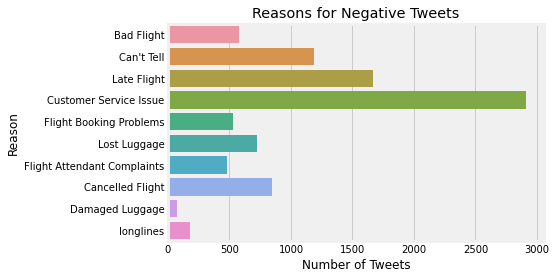

In [11]:
sns.countplot(y='negativereason',  data=data);
plt.title("Reasons for Negative Tweets");
plt.xlabel("Number of Tweets");
plt.ylabel("Reason");

Late flights and poor customer service are the leading causes for negative tweets.

For the purpose of this analysis we will only train on the tweet itself which is contained in the **text** column. Our target, which is the sentiment expressed in the tweet, is contained in the **airline_sentiment** comlumn. All other columns will be dropped. 

In [12]:
# drop all columns except text and airline_sentiment
data = data[['text', 'airline_sentiment']]

After removing the unwanted features we should be left with only two columns. We verify that now.

In [13]:
print("{:,} rows and {:,} columns.".format(data.shape[0],data.shape[1]))

14,640 rows and 2 columns.


In [14]:
# inspect the first five tweets
data.head() 

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


<a id="3"></a>
## Step 3: Text Preprocessing

A necessary step before modeling is to prep the text data before conversion to vectors. This prep work includes parsing out html tags, removing special characters, tokenization, lemmatization, etc. To this end, the text preprocessing will be accomplished in the following steps:


1. HTML tag removal using **Beautiful Soup**,
2. Special character removal using **regex**,
3. Use **spacy** for tokenization, lemmatization, stop word removal, and parsing out numbers and punctuation from the tokens. 
4. Finally, we join the tokens back into a clean line of text using **join** string function.

We will define a function for each one of these steps and then wrap them together into a single preprocessing function. Let's get started!



In [15]:
# remove html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# remove special characters
def remove_special_char(text):
  return re.sub('[!@#$]', ' ', text)

# tokenization, lemmatization, stop word removal, and conversion to lowercase
nlp = spacy.load("en_core_web_sm")
def lemmatize_stop_words(text):
  doc = nlp(text)
  lemma_list = [token.lemma_.lower() for token in doc if token.is_stop is False and token.is_alpha] # remove stop words, punctuation, numbers, and then convert to lowercase
  return lemma_list

# preprocessing pipeline
def preprocessor(text):
  text = strip_html(text)
  text = remove_special_char(text)
  text = lemmatize_stop_words(text)
  clean_text = " ".join(text) # convert back to text string
  return clean_text

In [16]:
import time
tic = time.time()
data['clean_text'] = data.text.apply(lambda x: preprocessor(x))
toc = time.time()
print("Text preprocessing runtime = {:.2f} mins".format((toc-tic)/60.0) )

Text preprocessing runtime = 2.48 mins


In [17]:
data.head()

,text,airline_sentiment,clean_text
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn say
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,virginamerica plus add commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,virginamerica today mean need trip
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,virginamerica aggressive blast obnoxious entertainment guest face little recourse
4,@VirginAmerica and it's a really big bad thing about it,negative,virginamerica big bad thing


<a id="4"></a>
## Step 4: Vectorization of Text Data

In this section we split the data into training and test sets, then we vectorize using two methodologies CountVectorizer and TfidfVectorizer. 

In [18]:
 # split text data into training and test sets
 train_text, test_text, y_train, y_test = train_test_split(data.clean_text, data.airline_sentiment, test_size=0.3, random_state=1)

In [65]:
 # Create keyword arguments to pass to the vectorizers.
kwargs = {
        'ngram_range': (1,1),  # Use 1-grams
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
        'min_df': 2,
        'max_features':1000 # maximum number of 1-grams to keep
}

# initialize CountVectorizer
count_vec = CountVectorizer(**kwargs)

# initialize TfidfVectorizer
tfidf_vec = TfidfVectorizer(**kwargs)

# fit vectorizers to the training texts
x_train_count_vec = count_vec.fit_transform(train_text).toarray()
x_train_tfidf_vec = tfidf_vec.fit_transform(train_text).toarray()

# Vectorize test texts
x_test_count_vec = count_vec.transform(test_text).toarray()
x_test_tfidf_vec = tfidf_vec.transform(test_text).toarray()

print("x_train_count_vec shape: {}".format(x_train_count_vec.shape))
print("x_train_tfidf_vec shape: {}".format(x_train_tfidf_vec.shape))
print("x_test_count_vec shape: {}".format(x_test_count_vec.shape))
print("x_test_tfidf_vec shape: {}".format(x_test_tfidf_vec.shape))

x_train_count_vec shape: (10248, 1000)
x_train_tfidf_vec shape: (10248, 1000)
x_test_count_vec shape: (4392, 1000)
x_test_tfidf_vec shape: (4392, 1000)


<a id="5"></a>
## Step 5: Model Fitting and Evaluation
In this section we fit a two logistic regression models. The first model will be fit using the vectorization obtained from CountVectorizer, and the second model will be fit using the vectorization obtained from TfidfVectorizer. We will then compare their cross validated accuracy scores.

In [107]:
# Logistic Regression
logreg = LogisticRegression()

# run 3-fold CV using CountVectorize data
count_vec_scores = cross_val_score(logreg, x_train_count_vec, y_train, cv=3, n_jobs=-1)

# run 3-fold CV using TfidfVectorizer data
tfidf_vec_scores = cross_val_score(logreg, x_train_tfidf_vec, y_train, cv=3, n_jobs=-1)

In [108]:
print("CountVectorizer 3-fold CV accuracy: {:.2f}".format(np.mean(count_vec_scores)))
print("TfidfVectorizer 3-fold CV accuracy: {:.2f}".format(np.mean(tfidf_vec_scores)))

CountVectorizer 3-fold CV accuracy: 0.76
TfidfVectorizer 3-fold CV accuracy: 0.77


The model using the TfidfVectorizer  performs slightly better than that using the CountVectorizer. Let's evaulate the better performing model on the test set.

In [109]:
# refit the model 
logreg.fit(x_train_tfidf_vec, y_train)

# evauluate on the test set
test_accuracy = logreg.score(x_test_tfidf_vec, y_test)
print("Accuracy on the test set: {:.2f}".format(test_accuracy))

Accuracy on the test set: 0.77


The similarity of the training and test scores indicate that the logistic regression model is not overfitting and is generalizing well to new data. Finally, let's have a look at the model's precision, recall, and F1 scores 

In [110]:
y_pred = logreg.predict(x_test_tfidf_vec)
print(classification_report(y_test, y_pred, target_names=['negative','neutral','positive']))

              precision    recall  f1-score   support

    negative       0.80      0.92      0.86      2741
     neutral       0.64      0.49      0.56       936
    positive       0.78      0.60      0.68       715

    accuracy                           0.77      4392
   macro avg       0.74      0.67      0.70      4392
weighted avg       0.77      0.77      0.76      4392



The model does very well at identifying negative reviews. This is exactly what we expected since 65% of all the reviews were negative. It does a decent job at identifying the positive reviews with a precision comparable to that of the negative class. It struggles the most with the neutral reviews with an f1 score of 0.56. 

<a id="6"></a>
## Step 6: Summary

In this project we set out to develop a model that could accurately capture the sentiment expressed in a line of text. There were several steps we had to take to arrive at this goal. First, we removed the html tags using **Beautiful Soup** and unwanted characters using **regex**. This helped to remove "noise" from the text. After that we leveraged the power of the **spacy** to perform the tasks of tokenization, lemmatization, stop word and punctuation removal all in just a few lines of code! After that we joined the tokens back into a clean line of text. From there we converted this clean text into numerical vectors using **CountVectorizer** and **TfidfVectorizer** from the sklearn feature_extraction.text package. With the preprocessing complete we compared the performance of two logistic regression models one of which was trained on the CountVectorizer data and the other on the TfidfVectorizer data. We observed a small performance gain when using the later. Finally we captured the performance of the model on the test set and noted that it performed quite well in predicting negative sentiment, decently well when predicting positive sentiment, and struggled to predict neutral sentiment accurately. The model achieved an overall accuracy of 0.77. 